In [10]:
import numpy as np
import pandas as pd
import copy
import tifffile as tf
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

In [14]:
#==================================== Defining values and functions ===========================================

size = 1200 # pixels
molecules = 100 # number of molecules in each frame
nframes = 50 # number of frames (keep number of frames smaller than 2000 for efficiency)
og_res = 65 # original resolution  (in nm)
distbins = np.arange(0, size*og_res+og_res, og_res) # binning (in nm)
ranges = [distbins, distbins]
movie = np.zeros((nframes, size, size)) # used at the end to make a movie using the frames

def generate_molecules(num_mol=None, size=size, og_res=og_res, mode='uniform'):
    if num_mol is None:
        num_mol = np.random.randint(10,15)
    if mode=='uniform':
        coords = np.random.rand(2, num_mol) *size*og_res    
    return coords


In [15]:
#================================= Step 1: generating molecules in a 2D space ==================================
# Generate molecules and get their initial states. 
# 0=off, 1=on, -1=bleached

sdf = {}
in_st = [] #initial state list
df=pd.DataFrame()

if molecules == 1:
    xcoords, ycoords = np.array([size*og_res/2 , size*og_res/2])
else:
    xcoords, ycoords = generate_molecules(molecules, size=size, og_res=og_res, mode='uniform')

coords=[]

for i in range(molecules):
   if molecules == 1:
       in_st.append(1)
   else:
       in_st.append(np.random.randint(0, 2))
    
df['state_f0'] = in_st

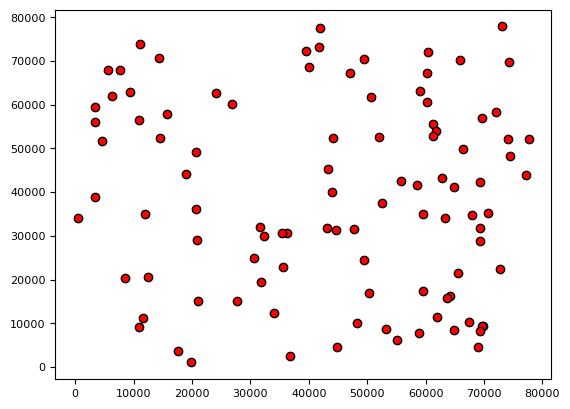

In [20]:
plt.scatter(xcoords, ycoords, marker='o', color='r', edgecolors='k')

In [25]:
#============================ Step 2: (Using Markov chain) Defining transition probabilities ===========================
# So far we have only worked on the first frame. Now, in the next frame, some molecules will change state and some won't.

states = ['on', 'off', 'bleached']
state_numbers = [1, 0, -1]
trans_matrix = [[0.3999, 0.60, 0.0001], [0.2099, 0.79, 0.0001], [0, 0, 1]]
state_matrix = np.zeros((molecules,nframes)).astype(int)
state_matrix[:,0] = df['state_f0']
state_list = []


for i in range(nframes-1):
    for j in range(molecules):
        state_matrix[j,i+1] = np.random.choice(state_numbers, size=1 , p=trans_matrix[state_numbers.index(state_matrix[j,i])])
    df['state_f{0}'.format(i+1)] = state_matrix[:,i+1]



In [26]:
#==================================== Step 3: Photon emission in all frames =========================================
# Assumption: Emission directly incident on the detector chip, no optics included.

newdf = copy.copy(df)
phcoords = {}

histed = {}
stds = 70 # nm


for i in range(nframes):
    nphot = [] # number of photons emitted for each molecule
    nphot_coords = [] # the locations of the photons on the detector
    ph_list = np.empty((1,2)) #dummy
    for j in range(molecules):
        if newdf.iloc[j,i]==1:
            nphot.append(np.random.randint(1000, 10000))           
            # coordinates where photons hit the detector for each molecule
            if molecules == 1:
                ph = np.random.normal(loc=(xcoords, ycoords), scale=(stds, stds), size=(nphot[-1], 2))
            else:
                ph = np.random.normal(loc=(xcoords[j], ycoords[j]), scale=(stds, stds), size=(nphot[-1], 2))
            # nphot_coords.append(ph) 
            ph_list = np.vstack((ph_list,ph))
        else:
            nphot.append(0)
    newdf['num_photons_f{0}'.format(i)] = nphot
    phcoords['phot_coords_f{0}'.format(i)] = ph_list[1:]
    movie[i] = np.histogram2d(x=phcoords['phot_coords_f{0}'.format(i)][:,0], y=phcoords['phot_coords_f{0}'.format(i)][:,1], bins=(distbins, distbins))[0]

In [27]:
# Adding noise to the signal 

movie=movie.astype(int)

# Adding noise
movie_w_noise = movie+np.random.normal()

# Adding background
movie_bkg_noise = movie_w_noise + np.random.uniform(low=0.0, high=100.0)

(<Figure size 988.8x604.8 with 3 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7ff0b06f8b80>)

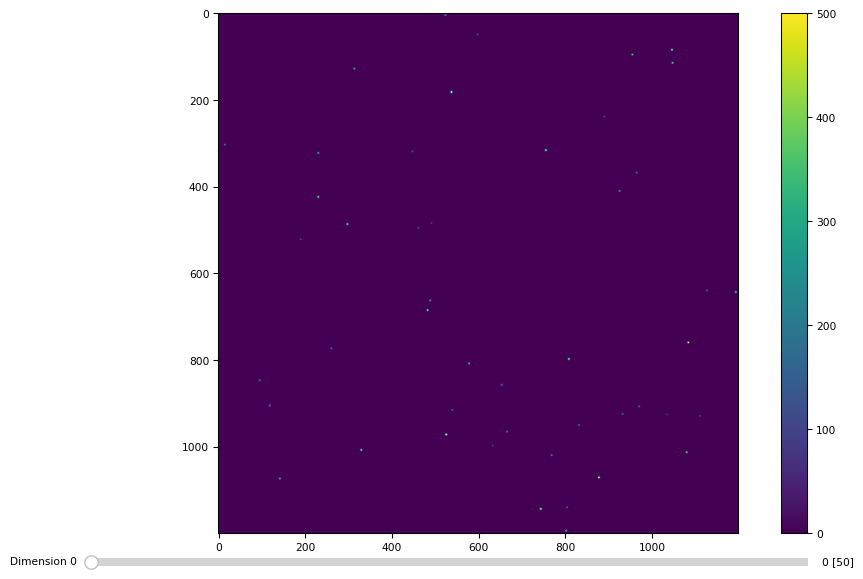

In [33]:
tf.imshow(movie,vmax=500) #check the movie

In [34]:
#====================================== Step 4: 2D Histograms to a movie ===============================================
# Plot the histogram here (to check) and convert into a movie. 

tf.imwrite("{0}_Molecules_{1}_Frames_Sim.tiff".format(molecules, nframes), data=movie_bkg_noise, shape=movie_bkg_noise.shape) # Save as TIFF file
